# **Implementation of Word2Vect - CBOW and Skip gram algorithm**


# Exercise Description

In this exercise, I will create my own implementation of word2vec for a small corpus using both most famous algorithms: CBOW and skipgram algorithms.

For this exercise, I will use Pytorch library and I will apply the following steps on both models:

*   First, apply one-hot vectors for data representation to the input layer.
*   For the training process I will use Cross Entropy as the loss function, optimizied with Adam.
*   Finally, I will use PCA to reduce the dimensionality of the word embeddings and visualize them in 2D.


To have final results of the models, I will:


*   Evaluating target words with the CBOW Model.
*   Finding the context words with Skip Gram Model.



---

# Abstract
## Continuous Bag of Words (CBOW)
Continuous Bag of Words (CBOW) is a neural network-based model used to predict a target word given its surrounding context words. This model focuses on the context around a word to predict the word itself. In other words, given a sentence, the CBOW model predicts the target word using its surrounding words (context).

**Architecture**


The CBOW model has three key layers:

*   Input Layer: This layer takes the surrounding context words, represented as one-hot vectors, as input.
*   Hidden Layer: It learns the word embeddings by transforming the one-hot input vectors into lower-dimensional vectors (the embeddings).
*   Output Layer: This layer predicts the target word (the word being predicted) by applying SoftMax, which gives a probability distribution over all possible words in the vocabulary.

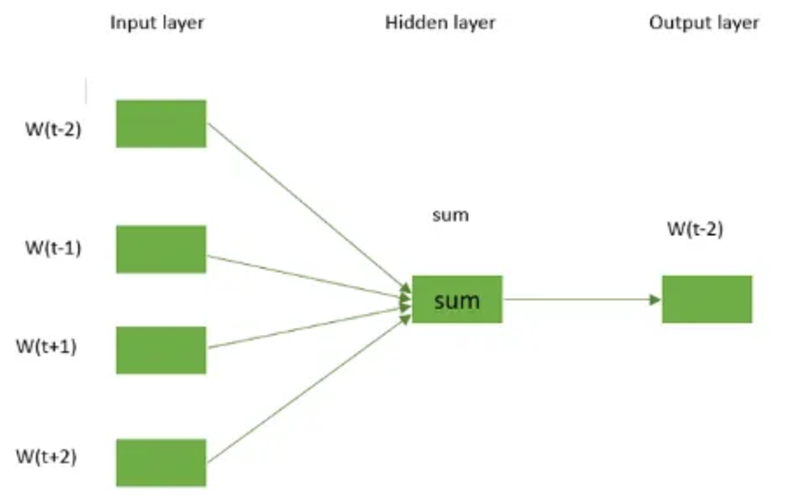
---
# Skip gram Model
The Skip-gram model is the reverse of CBOW. Instead of predicting the target word based on its context, Skip-gram predicts the context words given the target word. It tries to maximize the probability of predicting the surrounding words for a given target word.

**Architecture**

*   Input Layer: The target word is represented as a one-hot vector.
*   Hidden Layer: This learns the word embeddings (dense vectors).
*   Output Layer: The model predicts the surrounding context words for the given target word.


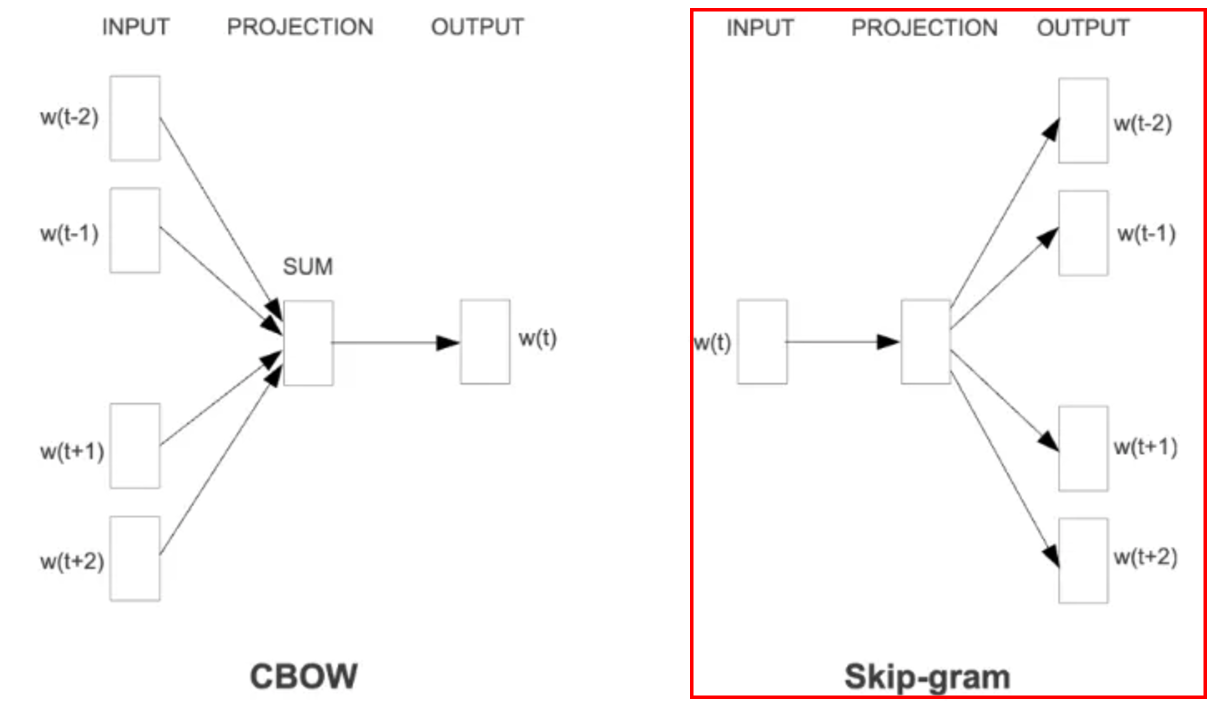




#1. Implementation of CBOW



**1.- Define the corpus for the exercise**

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
import numpy as np
import random
import matplotlib.pyplot as plt

#set seed for results in PyTorch
SEED = 44
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



#Define the corpus
corpus = ['The cat sat on the mat',
          'The dog ran in the park',
          'The bird sang in the tree']

#Encode the corpus to integers with tokens
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)

print ("Sequences of words in the corpus", sequences)

Sequences of words in the corpus [[1, 3, 4, 5, 1, 6], [1, 7, 8, 2, 1, 9], [1, 10, 11, 2, 1, 12]]


**2.- Set parameters**


In [80]:
#Vocabulary size
vocab_size = len(tokenizer.word_index) + 1

#Size of the word embeddings
embedding_dim = 20 #more dimensions => capture better relationships

#Context window size
window_size = 2

**3.- Generate Context-Target Pairs**

In [81]:
contexts = []
targets = []

for sequence in sequences:
  for i in range(window_size, len(sequence) - window_size):
    #calculate the sequences in the windows size
    contexts.append(sequence[i-window_size:i] + sequence[i+1:i+window_size+1])
    targets.append(sequence[i])

X = np.array(contexts)
y = np.array(targets)

print ("X Data Shape: ", X.shape)
print ("y Data Sahep: ", y.shape)

X Data Shape:  (6, 4)
y Data Sahep:  (6,)


**4.- Create Dataset**

In [82]:
class CBOWDataset(Dataset):
  def __init__(self, contexts, targets):
    self.contexts = torch.tensor(contexts, dtype=torch.long)
    self.targets = torch.tensor(targets, dtype=torch.long)

  def __len__(self):
    return len(self.contexts)

  def __getitem__(self, idx):
    return self.contexts[idx], self.targets[idx]


dataset = CBOWDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

**5.- Define CBOW model**

In [83]:
#Define the model of the neural network using PyTorch
class CBOWModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim):
    super(CBOWModel, self).__init__()
    self.embeddings = nn.Embedding(vocab_size, embedding_dim) #embedding layer
    self.linear = nn.Linear(embedding_dim, vocab_size)

  #forward step
  def forward(self, inputs):
    #Get embeddings fro the context words
    embedded  = self.embeddings(inputs)
    #Take the average of the context words to get a single vector
    embedded_mean = embedded.mean(dim=1)
    #Feed the linear layer to get the probability for the prediction
    out = self.linear(embedded_mean)
    return out


#Initialize the model
model = CBOWModel(vocab_size=vocab_size, embedding_dim=embedding_dim)
#Define loss funciton
criterion = nn.CrossEntropyLoss()
#Define Adam as the Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Neural Network Model: ", model)

Neural Network Model:  CBOWModel(
  (embeddings): Embedding(13, 20)
  (linear): Linear(in_features=20, out_features=13, bias=True)
)


**6.- Traning**

In [84]:
#Define number of epochs (iterations)
epochs = 200

for epoch in range(epochs):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for context, target in dataloader:
        optimizer.zero_grad()
        output = model(context)  #Model created before
        loss = criterion(output, target)  #Loss Function
        loss.backward()  #Backward step
        optimizer.step()  #Optimization step

        #Save the loss for visualizing
        total_loss += loss.item()

        #Calculate accuracy
        _, predicted = output.max(1)
        correct_predictions += (predicted == target).sum().item()
        total_predictions += target.size(0)

    # Calculate metrics
    accuracy = correct_predictions / total_predictions * 100

    # Imprimir métricas cada 10 épocas
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch: 0, Loss: 2.7778, Accuracy: 16.67%
Epoch: 10, Loss: 2.6388, Accuracy: 16.67%
Epoch: 20, Loss: 2.5073, Accuracy: 16.67%
Epoch: 30, Loss: 2.3834, Accuracy: 16.67%
Epoch: 40, Loss: 2.2666, Accuracy: 16.67%
Epoch: 50, Loss: 2.1564, Accuracy: 16.67%
Epoch: 60, Loss: 2.0520, Accuracy: 16.67%
Epoch: 70, Loss: 1.9527, Accuracy: 33.33%
Epoch: 80, Loss: 1.8580, Accuracy: 33.33%
Epoch: 90, Loss: 1.7673, Accuracy: 50.00%
Epoch: 100, Loss: 1.6802, Accuracy: 50.00%
Epoch: 110, Loss: 1.5965, Accuracy: 50.00%
Epoch: 120, Loss: 1.5159, Accuracy: 66.67%
Epoch: 130, Loss: 1.4383, Accuracy: 66.67%
Epoch: 140, Loss: 1.3635, Accuracy: 83.33%
Epoch: 150, Loss: 1.2915, Accuracy: 83.33%
Epoch: 160, Loss: 1.2221, Accuracy: 100.00%
Epoch: 170, Loss: 1.1555, Accuracy: 100.00%
Epoch: 180, Loss: 1.0915, Accuracy: 100.00%
Epoch: 190, Loss: 1.0302, Accuracy: 100.00%


**7.- Visualization using PCA**

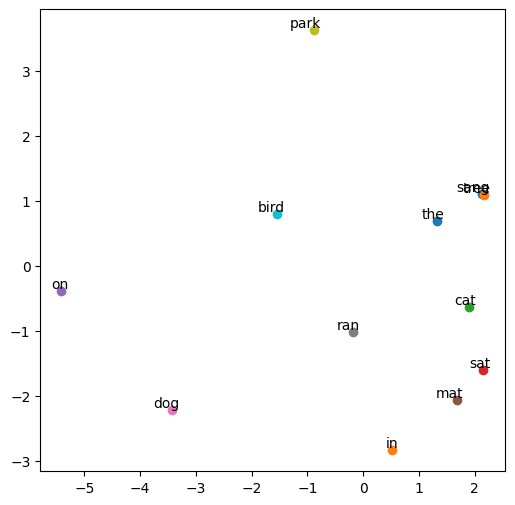

In [85]:
# Get the word embeddings from the trained CBOW model
embeddings = model.embeddings.weight.data.numpy()

# Use PCA to reduce dimensionality
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Visualize the word embeddings
plt.figure(figsize=(6,6))
for i, word in enumerate(tokenizer.word_index.keys()):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(word, (x, y), textcoords="offset points", xytext=(5,2),
                                                              ha='right')
plt.show()

**8.- Evaluating target words**

With the model created I will evaluate how well the model predicts the target word given the context.

In [86]:
context_words = ["the", "cat", "on", "the"]
context_indices = [tokenizer.word_index[word] for word in context_words]
context_tensor = torch.tensor([context_indices], dtype=torch.long)

# Pass the context to the model
output = model(context_tensor)

# Get the predicted target word
_, predicted_index = output.max(1)
index_to_word = {idx: word for word, idx in tokenizer.word_index.items()}
predicted_word = index_to_word[predicted_index.item()]

print(f"Context: {context_words} -> Predicted target word: '{predicted_word}'")

Context: ['the', 'cat', 'on', 'the'] -> Predicted target word: 'sat'


# 2.- Implementation of Skip gram Model

The setps 1 and 2 from the CBOW Model are used here too, those are the definition of the corpus and the definition of the parameters (vocab_size, embedding_size and window_size), i.e. we will keep the same values.

**3.- Generate Context-Target Pairs**

In [87]:
def generate_skipgram_data(sequences, window_size):
  contexts = []
  targets = []

  for sequence in sequences:
    for i in range(window_size, len(sequence) - window_size):
      #calculate the sequences in the windows size
      target = sequence[i]
      context_words = sequence[i-window_size:i] + sequence[i+1:i+window_size+1]
      for contexxt_word in context_words:
        contexts.append(contexxt_word)
        targets.append(target)

  return np.array(contexts), np.array(targets)

X, y = generate_skipgram_data(sequences, window_size)

print ("X Data Shape: ", X.shape)
print ("y Data Sahep: ", y.shape)

X Data Shape:  (24,)
y Data Sahep:  (24,)


**4.- Create Dataset**

In [88]:
class SkipGramDataset(Dataset):
  def __init__(self, contexts, targets):
    self.contexts = torch.tensor(contexts, dtype=torch.long)
    self.targets = torch.tensor(targets, dtype=torch.long)

  def __len__(self):
    return len(self.contexts)

  def __getitem__(self, idx):
    return self.contexts[idx], self.targets[idx]


dataset = SkipGramDataset(X, y)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

**5.- Define CBOW model**

In [89]:
#Define the model of the neural network using PyTorch
class SkipGramModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim):
    super(SkipGramModel, self).__init__()
    self.embeddings = nn.Embedding(vocab_size, embedding_dim) #embedding layer
    self.linear = nn.Linear(embedding_dim, vocab_size)

  #forward step
  def forward(self, inputs):
    #Get embeddings fro the context words
    embedded  = self.embeddings(inputs)
    #Feed the linear layer to get the probability for the prediction
    out = self.linear(embedded)
    return out


#Initialize the model
model_sg = SkipGramModel(vocab_size=vocab_size, embedding_dim=embedding_dim)
#Define loss funciton
criterion = nn.CrossEntropyLoss()
#Define Adam as the Optimizer
optimizer = optim.Adam(model_sg.parameters(), lr=0.001)

print("Neural Network Model: ", model_sg)

Neural Network Model:  SkipGramModel(
  (embeddings): Embedding(13, 20)
  (linear): Linear(in_features=20, out_features=13, bias=True)
)


**6.- Traning**

In [90]:
#Define number of epochs (iterations)
epochs = 200

for epoch in range(epochs):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for context, target in dataloader:
        optimizer.zero_grad()
        output = model_sg(context)  #Model created before
        loss = criterion(output, target)  #Loss Function
        loss.backward()  #Backward step
        optimizer.step()  #Optimization step

        #Save the loss for visualizing
        total_loss += loss.item()

        #Calculate accuracy
        _, predicted = output.max(1)
        correct_predictions += (predicted == target).sum().item()
        total_predictions += target.size(0)

    # Calculate metrics
    accuracy = correct_predictions / total_predictions * 100

    # Imprimir métricas cada 10 épocas
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch: 0, Loss: 31.4491, Accuracy: 0.00%
Epoch: 10, Loss: 23.9623, Accuracy: 33.33%
Epoch: 20, Loss: 20.1246, Accuracy: 50.00%
Epoch: 30, Loss: 17.5825, Accuracy: 54.17%
Epoch: 40, Loss: 15.7717, Accuracy: 54.17%
Epoch: 50, Loss: 14.4398, Accuracy: 54.17%
Epoch: 60, Loss: 13.4154, Accuracy: 54.17%
Epoch: 70, Loss: 12.6607, Accuracy: 54.17%
Epoch: 80, Loss: 12.1089, Accuracy: 54.17%
Epoch: 90, Loss: 11.7003, Accuracy: 54.17%
Epoch: 100, Loss: 11.3892, Accuracy: 54.17%
Epoch: 110, Loss: 11.1351, Accuracy: 54.17%
Epoch: 120, Loss: 10.9441, Accuracy: 54.17%
Epoch: 130, Loss: 10.8017, Accuracy: 54.17%
Epoch: 140, Loss: 10.6856, Accuracy: 54.17%
Epoch: 150, Loss: 10.5842, Accuracy: 45.83%
Epoch: 160, Loss: 10.5033, Accuracy: 50.00%
Epoch: 170, Loss: 10.4293, Accuracy: 54.17%
Epoch: 180, Loss: 10.3869, Accuracy: 54.17%
Epoch: 190, Loss: 10.3339, Accuracy: 50.00%


**7.- Visualization using PCA**

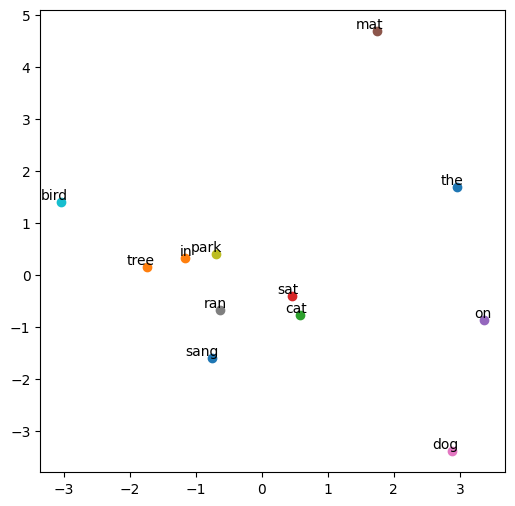

In [92]:
# Get the word embeddings from the trained Skip gram model
embeddings = model_sg.embeddings.weight.data.numpy()

# Use PCA to reduce dimensionality
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Visualize the word embeddings
plt.figure(figsize=(6,6))
for i, word in enumerate(tokenizer.word_index.keys()):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(word, (x, y), textcoords="offset points", xytext=(5,2), ha='right')
plt.show()

**8.- Finding Context Words**

With the model created I will evaluate how it predicts the context given a word.

In [93]:
# Get the embeddings from the trained layer
word_embeddings = model_sg.embeddings.weight.detach().numpy()

# Function to calculate cos similarity
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Find words most similar to a given word
def find_similar_words(word, tokenizer, embeddings, top_n=5):
    word_index = tokenizer.word_index[word]
    word_vector = embeddings[word_index]
    similarities = {}

    # Compare with all words in the vocabulary
    for w, idx in tokenizer.word_index.items():
        if w != word:  # Skip the same word
            other_vector = embeddings[idx]
            similarities[w] = cosine_similarity(word_vector, other_vector)

    # Sort by similarity and return the top_n words
    return sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:top_n]

target_word = "cat"
similar_words = find_similar_words(target_word, tokenizer, word_embeddings)
print(f"Words most similar to '{target_word}':", similar_words)

Words most similar to 'cat': [('park', 0.30269253), ('sang', 0.2952649), ('sat', 0.22448115), ('tree', 0.12923276), ('mat', 0.11581044)]


# Final Results

In this experiment I implemented two of the most well known algorithms of word2vec model: CBOW and Skip gram.

 **Analysis**


*   In CBOW model given the context I am able to predict the meaningful word; on the contrary, with Skip gram algorithm given the word I can predict the context.

*   CBOW is faster to train since it predicts one target word at a time, while Skip-gram can generate better embeddings for rare words, because it focuses on predicting multiple context words from a single target.

*   In terms of performance, skip-gram generally perfoms better for getting the relationship between rare words, but it requires more computational resources than CBOW.

*   After traning both models, using PCA (Principal Component Analysis) it was possible to reduce the dimensionality of the word embeddings in order to visualize in 2D.

# Future Work
For the future work, those models can be extended by using a large dataset instead of a sample of a corpus.